### Imports

In [46]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from statsmodels.tsa.stattools import adfuller  
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import acf, plot_acf, pacf, plot_pacf, seasonal_plot, month_plot, quarter_plot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

### Reading in Data

In [2]:
train = pd.read_csv('../brianna_folder/datasets/clean_train_avg_ridership.csv')

In [3]:
train.set_index(pd.DatetimeIndex(train['month_beginning']), inplace=True)
train.drop(columns=['month_beginning'], inplace=True)

In [4]:
train.head()

,station_id,station_name,avg_weekday_rides,avg_saturday_rides,avg_sunday-holiday_rides,month_total
month_beginning,,,,,,
2001-01-01,40900,Howard,6233.9,3814.5,2408.6,164447
2001-01-01,41190,Jarvis,1489.1,1054.0,718.0,40567
2001-01-01,40100,Morse,4412.5,3064.5,2087.8,119772
2001-01-01,41300,Loyola,4664.5,3156.0,1952.8,125008
2001-01-01,40760,Granville,3109.8,2126.0,1453.8,84189


In [5]:
# Redefining dataframe to pre-pandemic ridership.

In [6]:
train_pre_covid = train[train.index < '2020-03-01'].copy()

In [7]:
train_pre_covid = train_pre_covid.resample('MS', closed ='left').mean()

In [8]:
# Finding seasonality with acf and pacf

In [9]:
train_pre_covid['1st_diff_total'] = train_pre_covid['month_total'].diff(1)

In [10]:
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [11]:
interpret_dftest(adfuller(train_pre_covid['month_total']))

Test Statistic   -1.528761
p-value           0.519239
dtype: float64

In [12]:
interpret_dftest(adfuller(train_pre_covid['1st_diff_total'].dropna()))

Test Statistic   -3.253721
p-value           0.017078
dtype: float64

In [13]:
decomp_month_diff = seasonal_decompose(train_pre_covid['1st_diff_total'].dropna(), period = 12)

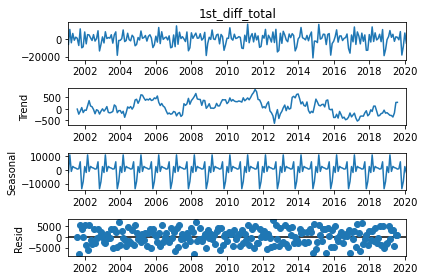

In [14]:
decomp_month_diff.plot();

In [15]:
decomp_month = seasonal_decompose(train_pre_covid['month_total'], period = 12)

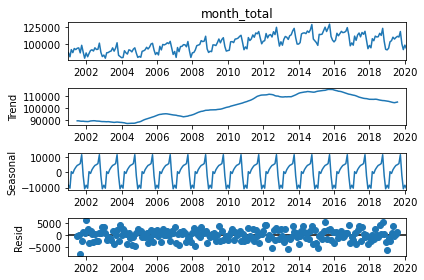

In [16]:
decomp_month.plot();

In [17]:
train_pre_covid['lag_1'] = train_pre_covid['1st_diff_total'].shift(1)
train_pre_covid['lag_2'] = train_pre_covid['1st_diff_total'].shift(2)
train_pre_covid['lag_3'] = train_pre_covid['1st_diff_total'].shift(3)

In [19]:
train_pre_covid.corr()

,station_id,avg_weekday_rides,avg_saturday_rides,avg_sunday-holiday_rides,month_total,1st_diff_total,lag_1,lag_2,lag_3
station_id,1.000000,0.613985,0.458173,0.468968,0.556380,-0.029522,-0.020975,-0.038569,-0.023130
avg_weekday_rides,0.613985,1.000000,0.886460,0.865942,0.944390,0.146090,0.288601,0.110710,0.053978
avg_saturday_rides,0.458173,0.886460,1.000000,0.944215,0.921706,0.104737,0.211894,0.226577,0.131196
avg_sunday-holiday_rides,0.468968,0.865942,0.944215,1.000000,0.924904,0.194019,0.227463,0.174659,0.210940
month_total,0.556380,0.944390,0.921706,0.924904,1.000000,0.294638,0.194161,0.187251,0.176363
1st_diff_total,-0.029522,0.146090,0.104737,0.194019,0.294638,1.000000,-0.168048,-0.017277,-0.014220
lag_1,-0.020975,0.288601,0.211894,0.227463,0.194161,-0.168048,1.000000,-0.165673,-0.021084
lag_2,-0.038569,0.110710,0.226577,0.174659,0.187251,-0.017277,-0.165673,1.000000,-0.161478
lag_3,-0.023130,0.053978,0.131196,0.210940,0.176363,-0.014220,-0.021084,-0.161478,1.000000


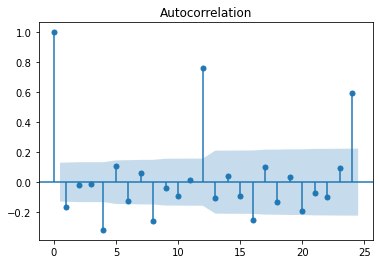

In [20]:
plot_acf(train_pre_covid['1st_diff_total'].dropna(), lags=24);

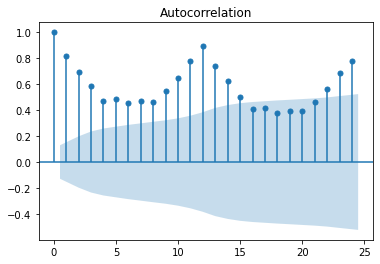

In [21]:
plot_acf(train_pre_covid['month_total'], lags=24);

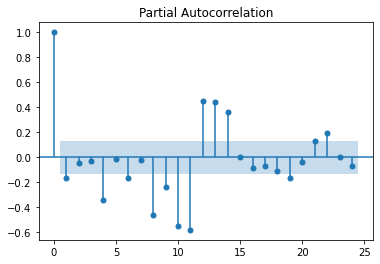

In [22]:
plot_pacf(train_pre_covid['1st_diff_total'].dropna(), lags=24);

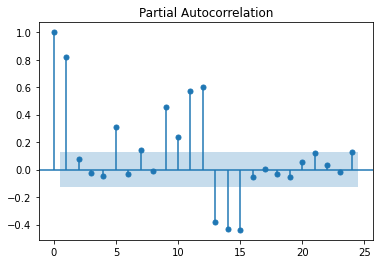

In [23]:
plot_pacf(train_pre_covid['month_total'], lags=24);

In [24]:
# There is yearly seasonality and a downward trend.

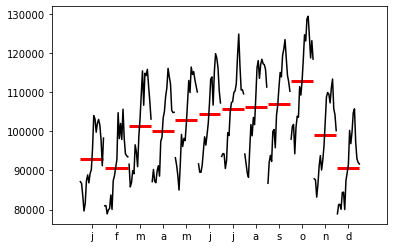

In [50]:
month_plot(train_pre_covid['month_total']);
plt.savefig('./assets/monthplot_train.png')

In [25]:
# Setting up dataframe for fitting.

In [26]:
# Creating columns for notable lags.

# Monthly
train_pre_covid['lag_1'] = train_pre_covid['1st_diff_total'].shift(1)

# Quarterly
train_pre_covid['lag_3'] = train_pre_covid['1st_diff_total'].shift(3)

# Yearly.
train_pre_covid['seasonal_12'] = train_pre_covid['1st_diff_total'].shift(12)

# Creating monthly index.
train_pre_covid['time'] = range(0, train_pre_covid.shape[0])

In [27]:
# Splitting
X_train, X_test, y_train, y_test = train_test_split(train_pre_covid.drop(columns = ['1st_diff_total']),
                                                    train_pre_covid['1st_diff_total'],
                                                    test_size = 0.25,
                                                    shuffle=False)

In [28]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(172, 10)
(58, 10)
(172,)
(58,)


In [29]:
# Linear Timeseries

In [30]:
X_train.dropna(inplace=True)
X_test.dropna(inplace=True)

y_train = y_train[X_train.index]

In [31]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [32]:
lm = sm.OLS(y_train, X_train)

In [33]:
lm_results = lm.fit()

In [34]:
lm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         1st_diff_total   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     45.96
Date:                Sun, 22 Aug 2021   Prob (F-statistic):           1.93e-40
Time:                        15:22:01   Log-Likelihood:                -1514.3
No. Observations:                 159   AIC:                             3051.
Df Residuals:                     148   BIC:                             3084.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     4.265e+06   3.15e+06      1.352      0.178   -1.97e+06    1.05e+07
station_id                -105.5349     77.419     -1.363      0.175    -258.524      47.454
avg_weekday_rides           -4.3878      3.016     -1.455      0.148     -10.348       1.573
avg_saturday_rides          -6.4209      3.260     -1.969      0.051     -12.864       0.022
avg_sunday-holiday_rides    -0.6888      2.633     -0.262      0.794      -5.892       4.515
month_total                  0.7436      0.131      5.671      0.000       0.484       1.003
lag_1                       -0.3048      0.051     -5.954      0.000      -0.406      -0.204
lag_2                       -0.1659      0.055     -3.026      0.003      -0.274      -0.058
lag_3                       -0.1974      0.052     -3.771      0.000      -0.301      -0.094
seasonal_12                  0.5275      0.057      9.216      0.000       0.414       0.641
time                       -56.2901     15.261     -3.689      0.000     -86.447     -26.133
==============================================================================
Omnibus:                        5.995   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.050   Jarque-Bera (JB):                5.723
Skew:                           0.458   Prob(JB):                       0.0572
Kurtosis:                       3.153   Cond. No.                     1.25e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.25e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [35]:
lm_results.predict(X_test)

month_beginning
2015-05-01    -2126.366716
2015-06-01    -2265.396557
2015-07-01     4608.253796
2015-08-01    -2937.924701
2015-09-01     4482.506267
2015-10-01    10645.321927
2015-11-01   -15403.770994
2015-12-01    -1018.447180
2016-01-01    -2642.590406
2016-02-01    -1637.942303
2016-03-01    10662.577202
2016-04-01    -4289.221984
2016-05-01    -1070.273794
2016-06-01     1243.440570
2016-07-01     1198.844201
2016-08-01    -1946.759259
2016-09-01     2371.167075
2016-10-01     5642.860401
2016-11-01   -13726.078404
2016-12-01    -8121.510392
2017-01-01    -1900.763382
2017-02-01    -4336.673915
2017-03-01     8986.913220
2017-04-01   -12015.922126
2017-05-01     1746.632600
2017-06-01    -2794.119463
2017-07-01    -6106.780626
2017-08-01     -214.295135
2017-09-01    -4057.331545
2017-10-01     5696.983332
2017-11-01   -13148.033181
2017-12-01   -16219.506085
2018-01-01        7.521260
2018-02-01   -10313.119302
2018-03-01     5658.771040
2018-04-01   -13794.340573
2018-05-01  

In [36]:
r2_score(y_test, lm_results.predict(X_test))

0.4977943670897085

In [37]:
mean_squared_error(y_test, lm_results.predict(X_test)) ** 0.5

5462.5955492866915

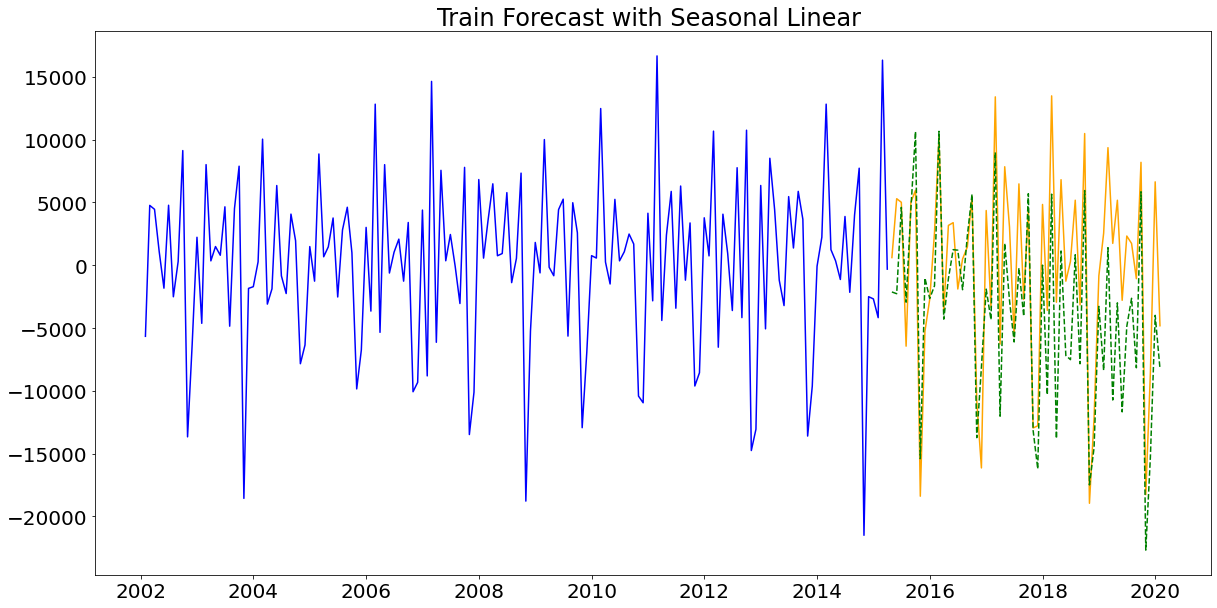

In [38]:
# Let's plot our predictions! 

# Set figure size.
plt.figure(figsize=(20,10))

# Plot training data.
plt.plot(y_train.index, y_train.values, color = 'blue')

# Plot testing data.
plt.plot(y_test.index, y_test.values, color = 'orange')

# Plot predicted test values.
plt.plot(lm_results.predict(X_test), color = 'green', ls='--')

# Set label.
plt.title(label = 'Train Forecast with Seasonal Linear ', fontsize=24)

# Resize tick marks.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);
plt.savefig('./assets/linear_forecast_train.png')